# **CIFAR-10 Colorization**

In this tutorial, we want to do an image colorization task using PyTorch on CIFAR-10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from copy import deepcopy
from random import shuffle
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

The following part defines a custom dataset class by extensing `torch.utils.data.Dataset`

**Output:** Both grayscale image and the RGB image

The `Grayscale` function confirms that the value of a grayscale pixel is the mean of values in all RGB channels

**Most importantly:** The code `Grayscale(num_output_channels = 3)` ensures that the grayscale images have also 3 channels. Actually, these three channels' contents are exactly the same. Just make sure that the number of channels will not change between input and output. So that a U-Net can be used.

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, train = False, download = True,
                 transform=transforms.ToTensor()):

        self.transform = transform
        self.dataset = torchvision.datasets.CIFAR10(root='./datasets',
                                                    transform = None,
                                                    train=train,
                                                    download=download)
        self.gray_transform = transforms.Grayscale(num_output_channels = 3)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        colored_image = self.dataset[idx][0] # Just to skip the labels by only reach [0] position in each item
        colored_image = self.transform(colored_image)
        gray_image = self.gray_transform(colored_image)
        return gray_image, colored_image


## Transforms & Dataset & Dataloader

Custom dataset class is used for defining the dataloader. Since both grayscale and colored images are expected to be used.

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
trainset = MyCustomDataset(transform = transforms.ToTensor(),
                                        train=True,
                                        download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12613561.38it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


### Splitting the train set and validation set.

In [ ]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, (train_size, val_size))

### Load the data

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

In [ ]:
n = 36
testset = MyCustomDataset(transform = transforms.ToTensor(),
                                        train=False,
                                        download=True)
testset_cropped = torch.utils.data.random_split(testset, (n, len(testset) - n))[0] # Randomly pick the test images, also ignore the labels
testloader = torch.utils.data.DataLoader(testset_cropped, batch_size=1024,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


## Dataset Visualization

Visualize the dataset (grayscale image along with the RGB image) by sampling from the trainset

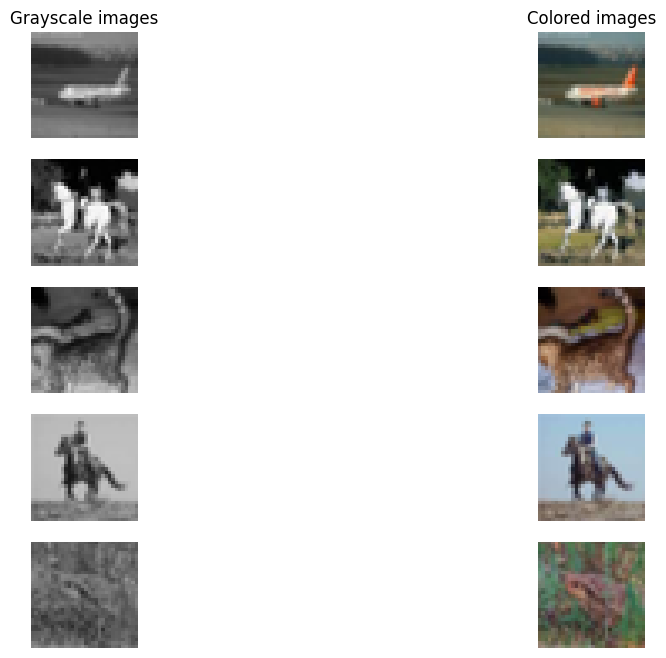

In [ ]:
gray_images = []
colored_images = []
i = 0
n = 5
k = 5

while len(gray_images) < n*k:
    x, y = trainset[i] # trainset is of type MyCustomDataset, so it will return two images, gray one and colored one
    gray_images.append(x)
    colored_images.append(y)
    i += 1

# Combining the grayscale images together with the colored ones correspondingly
temp = list(zip(gray_images, colored_images))
shuffle(temp)
gray_images, colored_images = zip(*temp)

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 8))

axes[0][0].set_title("Grayscale images")
axes[0][1].set_title("Colored images")

for j in range(n):
    axes[j][0].imshow(gray_images[j].permute(1, 2, 0).numpy())
    axes[j][1].imshow(colored_images[j].permute(1, 2, 0).numpy())
    axes[j][0].axis('off')
    axes[j][1].axis('off')

plt.show()

## Model

The model is defined here

**Input:** grayscale image with 3 channels

**Output:** RGB image with 3 channels

**Note:** The colorization task is expected to be completed by an autoencoder. Thus, U-Net is choose as the architecture of the network.


*UNet with the following architecture is used.*

*There are a dropout layer and a batchnorm layer after each Maxpool and each ConvTranspose.*

*\[Conv->Conv->MaxPool] is performed two times instead of four to still have a reasonable resolution at the lowest part of the architecture.*

![U-Net Structure](https://img-blog.csdnimg.cn/20210327133051736.png)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.copy1 = None
        self.copy2 = None
        self.copy3 = None
        self.copy4 = None
        self.conv1 = nn.Sequential(              #Originally 3   32  32
            nn.Conv2d(3, 64, 3, padding=1),     # 64  32  32
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),    # 64  32  32
            nn.ReLU()
        )
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                 # 64  16  16
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(64)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),    # 128  16  16
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),    # 128  16  16
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                 # 128  8   8
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),    # 256  8  8
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),    # 256  8  8
            nn.ReLU()
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride = 2, padding = 1,
                               output_padding = 1) #128 16 16
        )
        self.conv4 = nn.Sequential(               # 256 16 16
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, 3, padding=1),    # 128 16 16
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),    # 128 16 16
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1,
                               output_padding = 1) #64 32 32
        )
        self.conv5 = nn.Sequential(               # 128 32 32
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 3, padding=1),    # 64 32 32
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),    # 64 32 32
            nn.ReLU(),
            nn.Conv2d(64, 3, 1),       # 3 32 32
            nn.ReLU()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        self.copy1 = torch.clone(x)
        #print(f"made copy1: {self.copy1.shape}")
        x = self.down1(x)
        x = self.conv2(x)
        self.copy2 = torch.clone(x)
        #print(f"made copy2: {self.copy2.shape}")
        x = self.down2(x)
        x = self.conv3(x)
        x = self.up1(x)
        x = torch.cat((x,self.copy2),dim = 1)
        #print(f"concat copy2: {x.shape}")
        x = self.conv4(x)
        x = self.up2(x)
        x = torch.cat((x,self.copy1), dim = 1)
        #print(f"concat copy1: {x.shape}")
        x = self.conv5(x)
        #print(x.shape)
        return x

## Training

Outputs (after each epoch):
-  Things that are  to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
-  save train/validation loss (of each epoch) in an array for later usage (drawing the plot of changing in both train loss and validation loss)

### Using GPU

In [ ]:
net = UNet().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer`

#### Learning rate

In [ ]:
lr = 1e-3

#### MSE loss and Adam optimizer

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

### Training process

In [ ]:
def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    train_loss = 0

    net.train()

    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)

        loss = criterion(pred, y)
        train_loss += float(loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_loss

### Evaluation process

In [ ]:
def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    val_loss = 0

    net.eval()

    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)

        loss = criterion(pred, y)
        val_loss += float(loss)

    return val_loss

### Train Loop

In [ ]:
epochs = 100
train_loss_list = []
val_loss_list = []

for i in range(epochs):
    print(f"[Epoch {i}]")

    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader)

    print(f"Train Loss: {train_loss}")
    print(f"Validation Loss: {val_loss}")

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)


[Epoch 0]
Train Loss: 1.7696562898345292
Validation Loss: 0.11627222783863544
[Epoch 1]
Train Loss: 0.5832344614900649
Validation Loss: 0.07784165907651186
[Epoch 2]
Train Loss: 0.5480946614407003
Validation Loss: 0.07529412768781185
[Epoch 3]
Train Loss: 0.5229014377109706
Validation Loss: 0.07033210061490536
[Epoch 4]
Train Loss: 0.505397763568908
Validation Loss: 0.06550305336713791
[Epoch 5]
Train Loss: 0.49167463136836886
Validation Loss: 0.0667360252700746
[Epoch 6]
Train Loss: 0.481706362683326
Validation Loss: 0.06767844874411821
[Epoch 7]
Train Loss: 0.4685930567793548
Validation Loss: 0.059421445708721876
[Epoch 8]
Train Loss: 0.4636981701478362
Validation Loss: 0.06698658969253302
[Epoch 9]
Train Loss: 0.458114059176296
Validation Loss: 0.06673169042915106
[Epoch 10]
Train Loss: 0.4539641309529543
Validation Loss: 0.06350681511685252
[Epoch 11]
Train Loss: 0.4472396271303296
Validation Loss: 0.06346860248595476
[Epoch 12]
Train Loss: 0.442661443259567
Validation Loss: 0.0632

### Visualize Loss plot

Using the arrays that are recorded in the previous operation

Visualize the loss plot (train and validation together)

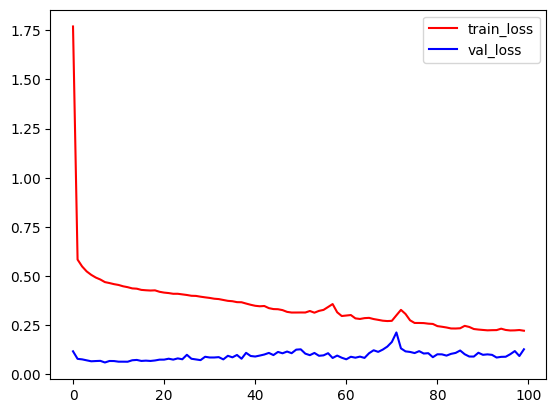

In [ ]:
x = list(range(epochs))
plt.plot(x, train_loss_list, 'r')
plt.plot(x, val_loss_list, 'b')
plt.legend(['train_loss', 'val_loss'])

plt.show()

## Evaluation

- Sample 36 random samples from testset (also in type MyCustomDataset)
- Give each of the 36 samples to the trained model and get the outputs
- Visualize `input` (grayscale image), `output` (the generated image output of the model with the given grayscale input image) and `ground truth` (the original RGB image)


In [ ]:
def test_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    test_loss = 0
    preds = []

    net.eval()

    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = net(x)

        preds.append(pred)

        loss = criterion(pred, y)
        test_loss += float(loss)

    return test_loss, preds

In [ ]:
test_loss, preds = test_epoch(net, criterion, testloader)

In [ ]:
torch.save(net.state_dict(), f"unet.pth")

In [ ]:
n = 36

x_l = []
y_l = []

for i,(x,y) in enumerate(testloader):
  x_l.append(x)
  y_l.append(y)

zipped = list(zip(x_l, y_l, preds))[0:n]
shuffle(zipped)
inputs, ground_truths, preds = zip(*zipped)


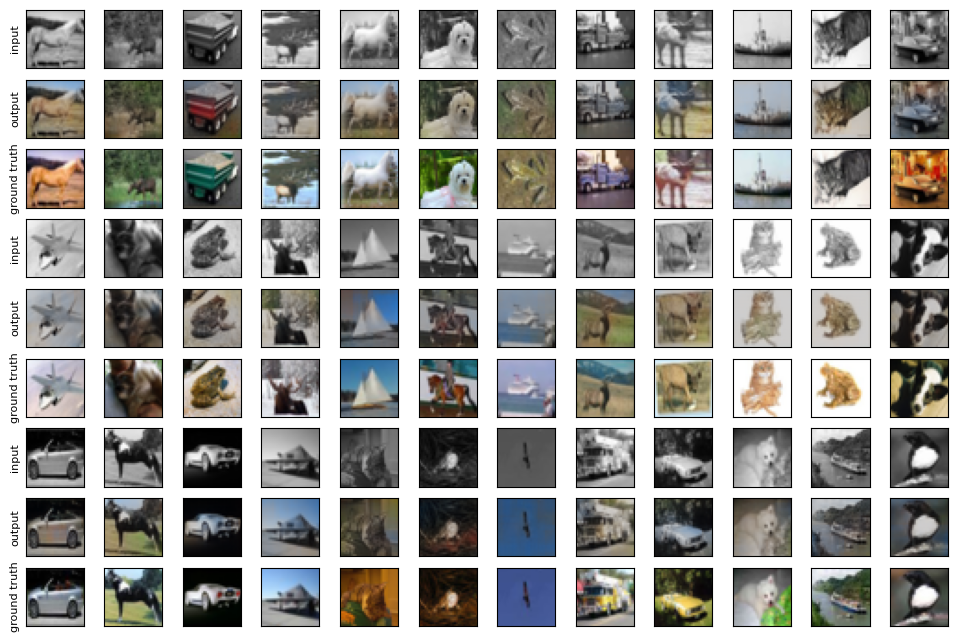

In [ ]:
inputs = []
ground_truths = []
predictions = []

i = 0

for i, (x,y) in enumerate(testloader):
  for j in range(x.shape[0]):
    inputs.append(x[j].cpu().data)
    ground_truths.append(y[j].cpu().data)
    predictions.append(preds[0][j].cpu().data)

fig, axes = plt.subplots(nrows=9, ncols=12, figsize=(12, 8))

for i, row in enumerate(axes):
  if i % 3 == 0:
    row[0].set_ylabel("input", fontsize=8)
  elif i % 3 == 1:
    row[0].set_ylabel("output", fontsize=8)
  else:
    row[0].set_ylabel("ground truth", fontsize=8)

for i in range(3):
  for j in range(12):
    axes[3*i][j].imshow(inputs[12*i+j].permute(1, 2, 0).numpy()) # it is  originally [3*i + j]
    axes[3*i+1][j].imshow(predictions[12*i+j].permute(1, 2, 0).numpy())
    axes[3*i+2][j].imshow(ground_truths[12*i+j].permute(1, 2, 0).numpy())
    axes[3*i][j].set_xticks([])
    axes[3*i+1][j].set_xticks([])
    axes[3*i+2][j].set_xticks([])
    axes[3*i][j].set_yticks([])
    axes[3*i+1][j].set_yticks([])
    axes[3*i+2][j].set_yticks([])


plt.show()